In [1]:
%matplotlib inline
import os
import h5py as h5
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd

# Analyse results of numerical experiments with integrators and interpolators

Before running through this notebook, make sure to build and run the fortran code to obtain simulation data to analyse. Running through the notebook will reproduce Figs. 5, B1 and B2 from Nordam and Duran (2020), except with a somewhat reduced number of datapoints, as it takes more than a day to run the full set of simulations. Do reproduce our results exactly, expand the number of timesteps and tolerances in parameters.f90

## Define some lists and dictionaries and things for convenience

In [2]:
# List of all implemented methods
methods = ['rk1', 'rk2', 'rk3', 'rk4', 'bs32', 'bs32s', 'dp54', 'dp54s', 'dp87', 'dp87s']

# Number of evaluations of RHS for each call to method
callfactor = {
    'rk1'   :  1,
    'rk2'   :  2,
    'rk3'   :  3,
    'rk4'   :  4,
    'bs32'  :  3,
    'bs32s' :  3,
    'dp54'  :  6,
    'dp54s' :  6,
    'dp87'  : 13,
    'dp87s' : 13,
}

# Consistent colors for plotting
colordict = {
    'rk1'   :  '#1f77b4',
    'rk2'   :  '#ff7f0e',
    'rk3'   :  '#2ca02c',
    'rk4'   :  '#d62728',
    'bs32'  :  '#9467bd',
    'bs32s' :  '#9467bd',
    'dp54'  :  '#e377c2',
    'dp54s' :  '#e377c2',
    'dp87'  :  '#7f7f7f',
    'dp87s' :  '#7f7f7f',
}

# Labels  for legends
namedict = {
    'rk1'   : 'R-K 1',
    'rk2'   : 'R-K 2',
    'rk3'   : 'R-K 3',
    'rk4'   : 'R-K 4',
    'bs32'  : 'B-S 3(2)',
    'bs32s' : 'B-S 3(2) special',
    'dp54'  : 'D-P 5(4)',
    'dp54s' : 'D-P 5(4) special',
    'dp87'  : 'D-P 8(7)',
    'dp87s' : 'D-P 8(7) special',
}

# Resolution labels
resolutiondict = {
    'norkyst800' : '800 m',
    'nordic4'    : '4 km',
    'arctic20'   : '20 km',
}

# Interpolation labels
interpdict = {
    'linear'  : 'linear',
    'cubic'   : 'cubic spline',
    'fifth'   : 'quintic spline',
    'quintic' : 'quintic spline',
}

## Functions to read data and calculate distances

In [3]:
def get_data(hdf5filepath):
    data = {}
    keys = []
    f = h5.File(hdf5filepath, 'r')
    for k, v in f.items():
        k = float(k)
        keys.append(k)
        data[k] = v.get('X')[:]

    keys = np.array(sorted(keys))
    return keys, data

def get_distances(X0, X, relative = True):
    if relative:
        return np.sqrt(np.sum((X0 - X)**2, axis = 1)) / np.sqrt(np.sum(X0**2, axis = 1))
    else:
        return np.sqrt(np.sum((X0 - X)**2, axis = 1))

## Function to plot error as a function of functioncalls or runtime

In [4]:
def plot_work_precision(interpolation, dataset, ref_integrator, ref_key, figsize = (12,7), ax = None, legend = False, error_range = False, runtime = False):
    # Path to results
    resultsfolder = '../results'
    
    # If no axes is passed as input, create new figure
    if ax is None:
        fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = figsize)

    # Load reference solution
    ref_hdf5file = os.path.join(resultsfolder, f'reference_{ref_integrator}_{dataset}_{interpolation}.hdf5')
    ref_keys, ref_data = get_data(ref_hdf5file)
    # Since keys are floats (timestep or tolerance)
    # find the one that is closest to the given refkey
    key = ref_keys[np.argmin(np.abs(ref_keys - ref_key))]
    X_ref = ref_data[key]
    
    # Loop over all integrators, and calculate errors relative to reference solution
    # (keeping dataset and interpolator fixed)
    for method in methods:
        
        # files with results
        hdf5file = os.path.join(resultsfolder, f'experiment_{method}_{dataset}_{interpolation}.hdf5')
        textfile = os.path.join(resultsfolder, f'experiment_{method}_{dataset}_{interpolation}.txt')
        # Load timing and numer of calls from txt file
        names = ['timestep or tolerance', 'runtime', 'Naccepted', 'Nrejected']
        timing = pd.read_csv(textfile, delim_whitespace = True, names = names, skiprows = 1)
        # Load particle positions for that method
        keys, data = get_data(hdf5file)

        # Arrays to hold error and percentiles
        errors  = np.zeros(len(keys))
        pct_95  = np.zeros(len(keys))
        pct_05  = np.zeros(len(keys))
        # Array to hold number of calls _or_ runtimes
        # (these go on the x axis)
        xvalues = np.zeros(len(keys))
        
        # Loop over timesteps or tolerances
        for i, key in enumerate(keys):
            # Get positions and calculate error
            X = data[key]
            Np = max(X.shape)
            distances = get_distances(X_ref, X)
            errors[i] = np.median(distances)
            pct_95[i] = np.percentile(distances, 95)
            pct_05[i] = np.percentile(distances, 5)
            
            # Here we decide what goes on the x axis
            # First extract one row from dataframe for convenience
            row = timing[timing['timestep or tolerance'] == key]
            if runtime:
                # Plotting error as function of runtime
                xvalues[i] = row['runtime']
            else:
                # Plotting error as function of number of evaluations
                # of the RHS of the ODE (per particle)
                xvalues[i] = (row['Naccepted'] + row['Nrejected']) * callfactor[method] / Np
        
        # Label and color for the line plot
        label = namedict[method]
        color = colordict[method]
        # Linetype (dashed for special-purpose)
        if method[-1] == 's':
            linetype = '--'
        else:
            linetype = '-'
        
        # Plot error as function of runtime or number of evaluations
        # (whichever is in the xvalues array)
        ax.plot(xvalues, errors, linetype, marker = '.', c = color, lw = 1, markersize = 3, label = label)
        # Plot range of errors, if so desired, using the same color as the corresponding line
        if error_range:
            ax.fill_between(xvalues, pct_05, pct_95, color = color, lw = 1, alpha=0.5)

    # Set logscale and white background
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_facecolor('w')
    
    # Hackety-hack to place the text describing resolution and dataset
    if runtime:
        ax.text(1.5e3/10, 2e-4, f'{resolutiondict[dataset]}, {interpdict[interpolation]}')
    else:
        ax.text(1.5e3, 2e-4, f'{resolutiondict[dataset]}, {interpdict[interpolation]}')
        
    # Add legend, if desired
    if legend:
        ax.legend(loc = 'upper right')
        
    return ax

## Test the plotting function for one single case

Text(0, 0.5, 'Median error [m]')

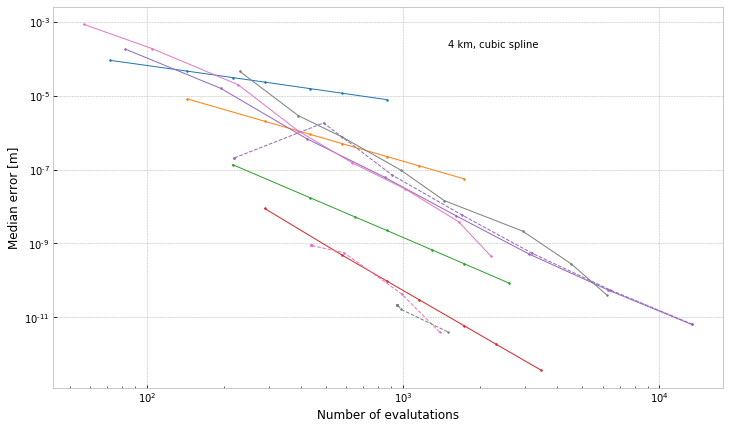

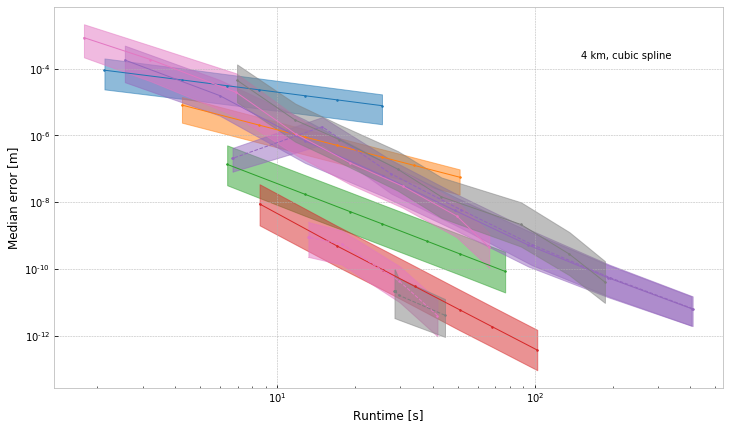

In [5]:
interpolation = 'cubic'
dataset = 'nordic4'

# Plot error as function of number of evaluations
ax = plot_work_precision(interpolation, dataset, ref_integrator = 'rk4', ref_key = 60)
ax.set_xlabel('Number of evalutations')
ax.set_ylabel('Median error [m]')

# Plot error as function of runtime
ax = plot_work_precision(interpolation, dataset, ref_integrator = 'rk4', ref_key = 60, error_range = True, runtime = True)
ax.set_xlabel('Runtime [s]')
ax.set_ylabel('Median error [m]')

## Plot error as function of no. of evalutions, for all datasets and interpolations

This corresponds to Fig. 5 in Nordam and Duran (2020)

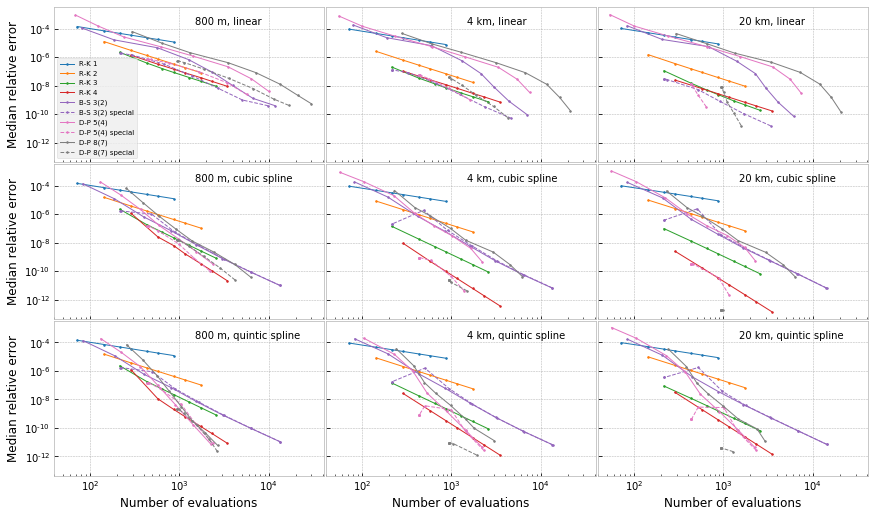

In [6]:
# List of the three datasets used
datasets = ['norkyst800', 'nordic4', 'arctic20']
# List of the three interpolation levels used
interpolations = ['linear', 'cubic', 'quintic']
# Reference timestep, for use with 4th-order Runge-Kutta
# (see Appendix A in Nordam and Duran (2020) for details)
# Array containing the values from Table A2 in Nordam and Duran (2020):

#ref_key = np.array([
#    [1,  1,  1],
#    [5, 30, 30],
#    [5, 30, 30],
#])

# Here, in the interest of faster runtimes, we simply use a fixed referenc timestep of 60 seconds
ref_key = np.array([
    [60, 60, 60],
    [60, 60, 60],
    [60, 60, 60],
])

# Create figure
fig, ax = plt.subplots(ncols=3, nrows=3, figsize = (12,7), sharex=True, sharey=True)

# Loop over interpolation methods and datasets
for i, interpolation in enumerate(interpolations):
    for j, dataset in enumerate(datasets):
        plot_work_precision(interpolation, dataset, ref_integrator = 'rk4', ref_key = ref_key[i,j], ax = ax[i,j], legend = False)

# Add axis labels along left side and bottom
for i in range(3):
    ax[i,0].set_ylabel('Median relative error')
    ax[2,i].set_xlabel('Number of evaluations')

# Add legend in one subplot only (they are all identical)
ax[0,0].legend(fontsize=7, loc='lower left')

# Tweak to reduce whitespace around figure
plt.subplots_adjust(left = 0.055, bottom = 0.065, right = 0.9975, top = 0.995, wspace=0.007, hspace=0.012)

# Uncomment to save file
#plt.savefig('work_precision_all_functioncalls.pdf')

## Plot error as function of no. of evalutions, for all datasets and interpolations, with error range

This corresponds to Fig. B1 in Nordam and Duran (2020)

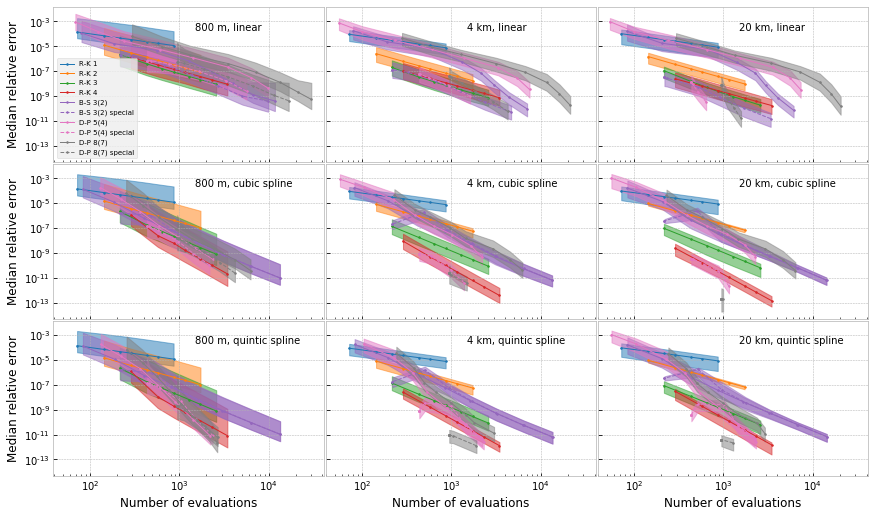

In [7]:
# List of the three datasets used
datasets = ['norkyst800', 'nordic4', 'arctic20']
# List of the three interpolation levels used
interpolations = ['linear', 'cubic', 'quintic']
# Reference timestep, for use with 4th-order Runge-Kutta
# (see Appendix A in Nordam and Duran (2020) for details)
# Array containing the values from Table A2 in Nordam and Duran (2020):

#ref_key = np.array([
#    [1,  1,  1],
#    [5, 30, 30],
#    [5, 30, 30],
#])

# Here, in the interest of faster runtimes, we simply use a fixed referenc timestep of 60 seconds
ref_key = np.array([
    [60, 60, 60],
    [60, 60, 60],
    [60, 60, 60],
])

# Create figure
fig, ax = plt.subplots(ncols=3, nrows=3, figsize = (12,7), sharex=True, sharey=True)

# Loop over interpolation methods and datasets
for i, interpolation in enumerate(interpolations):
    for j, dataset in enumerate(datasets):
        plot_work_precision(interpolation, dataset, ref_integrator = 'rk4', ref_key = ref_key[i,j], ax = ax[i,j], legend = False, error_range = True)

# Add axis labels along left side and bottom
for i in range(3):
    ax[i,0].set_ylabel('Median relative error')
    ax[2,i].set_xlabel('Number of evaluations')

# Add legend in one subplot only (they are all identical)
ax[0,0].legend(fontsize=7, loc='lower left')

# Tweak to reduce whitespace around figure
plt.subplots_adjust(left = 0.055, bottom = 0.065, right = 0.9975, top = 0.995, wspace=0.007, hspace=0.012)

# Uncomment to save file
#plt.savefig('work_precision_all_functioncalls_with_range.pdf')

## Plot error as function of runtime, for all datasets and interpolations

This corresponds to Fig. B2 in Nordam and Duran (2020)

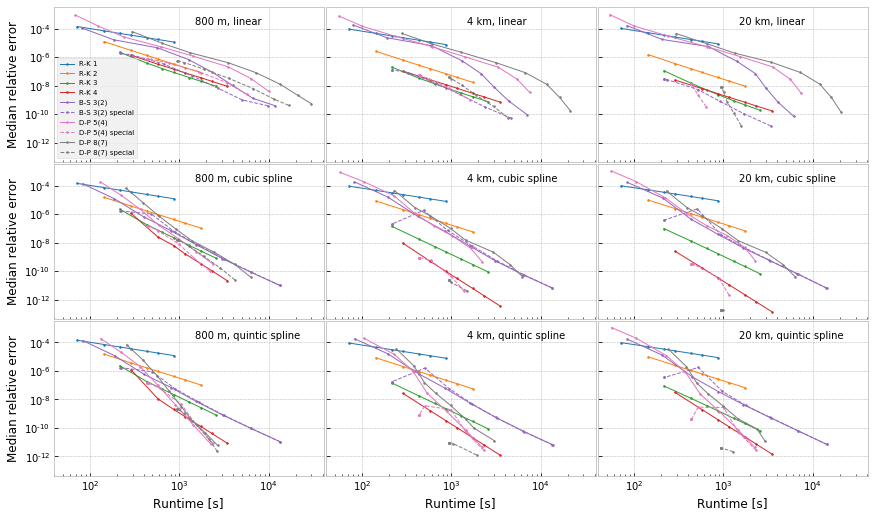

In [8]:
# List of the three datasets used
datasets = ['norkyst800', 'nordic4', 'arctic20']
# List of the three interpolation levels used
interpolations = ['linear', 'cubic', 'quintic']
# Reference timestep, for use with 4th-order Runge-Kutta
# (see Appendix A in Nordam and Duran (2020) for details)
# Array containing the values from Table A2 in Nordam and Duran (2020):

#ref_key = np.array([
#    [1,  1,  1],
#    [5, 30, 30],
#    [5, 30, 30],
#])

# Here, in the interest of faster runtimes, we simply use a fixed referenc timestep of 60 seconds
ref_key = np.array([
    [60, 60, 60],
    [60, 60, 60],
    [60, 60, 60],
])

# Create figure
fig, ax = plt.subplots(ncols=3, nrows=3, figsize = (12,7), sharex=True, sharey=True)

# Loop over interpolation methods and datasets
for i, interpolation in enumerate(interpolations):
    for j, dataset in enumerate(datasets):
        plot_work_precision(interpolation, dataset, ref_integrator = 'rk4', ref_key = ref_key[i,j], ax = ax[i,j], legend = False, runtime = False)

# Add axis labels along left side and bottom
for i in range(3):
    ax[i,0].set_ylabel('Median relative error')
    ax[2,i].set_xlabel('Runtime [s]')

# Add legend in one subplot only (they are all identical)
ax[0,0].legend(fontsize=7, loc='lower left')

# Tweak to reduce whitespace around figure
plt.subplots_adjust(left = 0.055, bottom = 0.065, right = 0.9975, top = 0.995, wspace=0.007, hspace=0.012)

# Uncomment to save file
#plt.savefig('work_precision_all_runtime.pdf')